# Auto-labeling Pipeline for Driving Scenes

In this notebook we bring everything together in a realistic (although simplistic) application: auto-labeling for self-driving cars. This is often the first level of data curation, typically followed by manual screening.

We will:
1. Classify images into the time of day as well as driving conditions
2. Run object detection to find cars and trucks
3. Segment the detections

in one unified pipelines (our application).

## Helper functions

Let's start by defining some helper functions:

In [ ]:
import torch
from typing import List, Union, Dict, Tuple
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
import numpy as np

# Only needed on the Udacity workspace. Comment this out if running on another system.
import os
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"


def get_distinct_colors(n_colors):
    if n_colors <= 10:
        cmap = plt.cm.tab10
    elif n_colors <= 20:
        cmap = plt.cm.tab20
    else:
        cmap = plt.cm.tab20
        # Cycle through colors if more than 20

    colors = [cmap(i % cmap.N) for i in range(n_colors)]
    return colors


def visualize_detr_detections(
    image: Image.Image,
    boxes: torch.Tensor,
    scores: torch.Tensor,
    labels: torch.Tensor,
    class_labels: List[str],
):
    """
    Visualize DETR detections with bounding boxes, confidence scores, and labels.
    """

    # Visualize detections
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image, mode='RGBA')

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        label_id = int(label.item())

        # Draw bounding box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

        # Draw label and confidence score
        class_name = class_labels[label_id]
        text = f"{class_name}: {score:.2f}"
        draw.text((x1, y1 - 20), text, fill="red")

    fig, sub = plt.subplots(figsize=(12, 8))
    sub.imshow(draw_image)
    sub.set_title("RT-DETR Car Detections")
    sub.axis("off")

    plt.show(fig)


def visualize_pipeline_results(image, time_pred, time_conf, weather_pred, weather_conf, masks):
    """
    Visualize complete pipeline results with classifications and segmentation masks.
    """
    fig, sub = plt.subplots(1, 1, figsize=(15, 10))

    # Show original image with slight transparency
    sub.imshow(image, alpha=0.7)

    # Overlay segmentation masks if any
    if len(masks) > 0:
        colors = get_distinct_colors(len(masks))

        for i, mask in enumerate(masks):
            colored_mask = np.zeros((*mask.shape, 4))
            color_rgb = colors[i][:3]
            colored_mask[mask > 0, :3] = color_rgb
            colored_mask[mask > 0, 3] = 0.6
            sub.imshow(colored_mask)

    # Add classification results as text
    title = f"Auto-labeling Results\n" \
            f"Time: {time_pred} ({time_conf:.2f}) | " \
            f"Weather: {weather_pred} ({weather_conf:.2f})\n" \
            f"Objects detected and segmented: {len(masks)}"
    
    sub.set_title(title, fontsize=12, pad=20)
    sub.axis("off")

    plt.tight_layout()
    plt.show()

## Load Models

Here we load all the models we'll need:

In [2]:
from transformers import CLIPProcessor, CLIPModel
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
from transformers import Sam2Processor, Sam2Model

# Load CLIP model for scene classification
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load RT-DETR model trained on COCO
detr_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
detr_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")

# Load SAM2.1 model
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-base-plus").to(device)
sam_processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-base-plus")

# Define classification labels
TIME_OF_DAY_LABELS = ["sunset or sunrise", "day", "night"]
WEATHER_LABELS = ["normal", "rain", "fog", "clouds", "snow"]

print("All models loaded successfully")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

All models loaded successfully


## Core Pipeline Functions

Now let's define the core functions for each step of the pipeline:

In [3]:
def classify_driving_conditions(image: Image.Image) -> Dict[str, Union[str, float]]:

    # TODO: Run clip_processor on the TIME_OF_DAY_LABELS and the input image
    # Reminder: clip_processor(text=[your text], images=[your image], return_tensor="pt", padding=True)
    time_inputs = clip_processor(
        text=TIME_OF_DAY_LABELS, images=image, return_tensors="pt", padding=True
    )

    with torch.no_grad():
        # TODO: run the clip model on the pre-processed inputs
        time_outputs = clip_model(**time_inputs)

        # Extract probabilities for the different classes
        time_logits = time_outputs.logits_per_image[0]
        time_probs = torch.softmax(time_logits, dim=-1)
    
    time_prediction = TIME_OF_DAY_LABELS[torch.argmax(time_probs)]
    time_confidence = torch.max(time_probs).item()

    # Same for weather condition
    weather_inputs = clip_processor(
        text=WEATHER_LABELS, images=image, return_tensors="pt", padding=True
    )

    with torch.no_grad():
        weather_outputs = clip_model(**weather_inputs)
        weather_logits = weather_outputs.logits_per_image[0]
        weather_probs = torch.softmax(weather_logits, dim=-1)

    weather_prediction = WEATHER_LABELS[torch.argmax(weather_probs)]
    weather_confidence = torch.max(weather_probs).item()

    return {
        "time_of_day": time_prediction,
        "time_confidence": time_confidence,
        "weather": weather_prediction,
        "weather_confidence": weather_confidence,
    }

In [14]:
def detect_vehicles_and_people(
    image: Image.Image,
    threshold: float = 0.3,
    iou_threshold_for_dashboard_removal: float = 0.8,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Detect vehicles and people in image using RT-DETR.

    Args:
        image: PIL Image to process
        threshold: Detection confidence threshold

    Returns:
        Tuple of (boxes, scores, labels) for detected vehicles and people
    """
    # TODO: Process image for RT-DETR
    inputs = detr_processor(images=image, return_tensors="pt")

    # Run inference
    with torch.no_grad():
        # TODO: run the detr_model on our pre-processed inputs
        outputs = detr_model(**inputs)

    # Post-process results
    results = detr_processor.post_process_object_detection(
        outputs, target_sizes=torch.tensor([image.size[::-1]]), threshold=threshold
    )

    # Filter for vehicles and people only (person=0, car=2, bus=5, truck=7)
    all_boxes = results[0]["boxes"]
    all_scores = results[0]["scores"]
    all_labels = results[0]["labels"]

    vehicle_classes = [0, 2, 5, 7]  # person, car, bus, truck
    vehicle_mask = torch.isin(all_labels, torch.tensor(vehicle_classes))

    boxes = all_boxes[vehicle_mask]
    scores = all_scores[vehicle_mask]
    labels = all_labels[vehicle_mask]

    # Filter out boxes with high IoU with whole image (dashboard removal)
    if len(boxes) > 0:
        img_width, img_height = image.size
        img_area = img_width * img_height

        # Calculate box areas
        box_areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

        # IoU with whole image is just box_area / img_area (since box is always inside image)
        ious = box_areas / img_area

        # Keep boxes with IoU less than threshold
        keep_mask = ious < iou_threshold_for_dashboard_removal
        boxes = boxes[keep_mask]
        scores = scores[keep_mask]
        labels = labels[keep_mask]

    return boxes, scores, labels

In [15]:
def segment_vehicles_and_people(image: Image.Image, boxes: torch.Tensor) -> List[torch.Tensor]:
    """
    Segment vehicles and people using SAM2.1 given bounding boxes.
    
    Args:
        image: PIL Image to process
        boxes: Bounding boxes from vehicle detection
        
    Returns:
        List of segmentation masks
    """
    if len(boxes) == 0:
        return []
    
    # TODO: Run Sam 2.1 on our image, using the boxes from 
    # the object detection stage as prompts
    inputs = sam_processor(
        images=image,
        input_boxes=[boxes],
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        # TODO: Run the SAM model
        outputs = sam_model(**inputs)

    masks = sam_processor.post_process_masks(
        outputs.pred_masks.cpu(), inputs["original_sizes"]
    )[0]

    # Get IoU scores to select best mask for each box
    iou_scores = outputs.iou_scores.cpu()

    # Select the best mask for each box based on highest IoU score
    best_masks = []
    for i in range(masks.shape[0]):
        best_mask_idx = torch.argmax(iou_scores[0, i])
        best_mask = masks[i, best_mask_idx]
        best_masks.append(best_mask)

    return best_masks

In [ ]:
def auto_label_driving_scene(
    images: Union[Image.Image, List[Image.Image]], 
    detection_threshold: float = 0.3
) -> List[Dict]:
    """
    Complete auto-labeling pipeline for driving scenes.

    Args:
        images: Single PIL Image or list of PIL Images
        detection_threshold: Confidence threshold for vehicle detection

    Returns:
        List of dictionaries containing results for each image:
        {
            'image_idx': int,
            'time_of_day': str,
            'time_confidence': float,
            'weather': str,
            'weather_confidence': float,
            'num_vehicles': int,
            'vehicle_boxes': torch.Tensor,
            'vehicle_scores': torch.Tensor,
            'vehicle_labels': torch.Tensor,
            'vehicle_masks': List[torch.Tensor]
        }
    """
    # Handle single image case
    if isinstance(images, Image.Image):
        images = [images]

    results = []

    for idx, image in enumerate(images):
        print(f"Processing image {idx + 1}/{len(images)}...")

        # Step 1: Classify driving conditions
        conditions = classify_driving_conditions(image)

        # Step 2: Detect vehicles
        boxes, scores, labels = detect_vehicles_and_people(image, detection_threshold)

        # Step 3: Segment vehicles
        masks = segment_vehicles_and_people(image, boxes)

        # Compile results
        result = {
            "image_idx": idx,
            "time_of_day": conditions["time_of_day"],
            "time_confidence": conditions["time_confidence"],
            "weather": conditions["weather"],
            "weather_confidence": conditions["weather_confidence"],
            "num_vehicles_and_people": len(boxes),
            "boxes": boxes,
            "scores": scores,
            "labels": labels,
            "masks": masks,
        }

        results.append(result)

        print(f"  Found {len(boxes)} objects (vehicles and people).")
        print(
            f"  Time: {conditions['time_of_day']} ({conditions['time_confidence']:.2f})"
        )
        print(
            f"  Weather: {conditions['weather']} ({conditions['weather_confidence']:.2f})"
        )

    return results

## Load Sample Image and Test Pipeline

Let's load a sample driving image and test our complete pipeline:

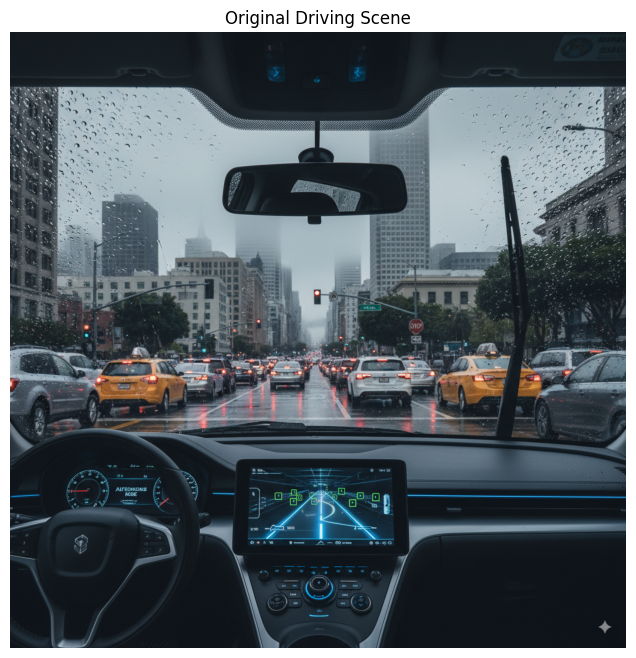

In [29]:
# Here you can use images/one.png, images/two.png, images/three.png or images/four.png
image = Image.open("../images/one.png")

# Display original image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.title("Original Driving Scene")
plt.axis("off")
plt.show()

## Run Complete Pipeline

Now let's run our complete auto-labeling pipeline:

In [30]:
# Run the complete pipeline
results = auto_label_driving_scene([image.convert("RGB")])

# Get results for our single image
result = results[0]

print("\nComplete Pipeline Results:")
print(f"Time of day: {result['time_of_day']} (confidence: {result['time_confidence']:.3f})")
print(f"Weather: {result['weather']} (confidence: {result['weather_confidence']:.3f})")
print(f"Vehicles and people detected: {result['num_vehicles_and_people']}")
print(f"Segmentation masks generated: {len(result['masks'])}")

Processing image 1/1...
  Found 18 objects (vehicles and people).
  Time: day (0.75)
  Weather: rain (0.85)

Complete Pipeline Results:
Time of day: day (confidence: 0.749)
Weather: rain (confidence: 0.854)
Vehicles and people detected: 18
Segmentation masks generated: 18


## Visualize Results

Let's visualize the complete pipeline results:

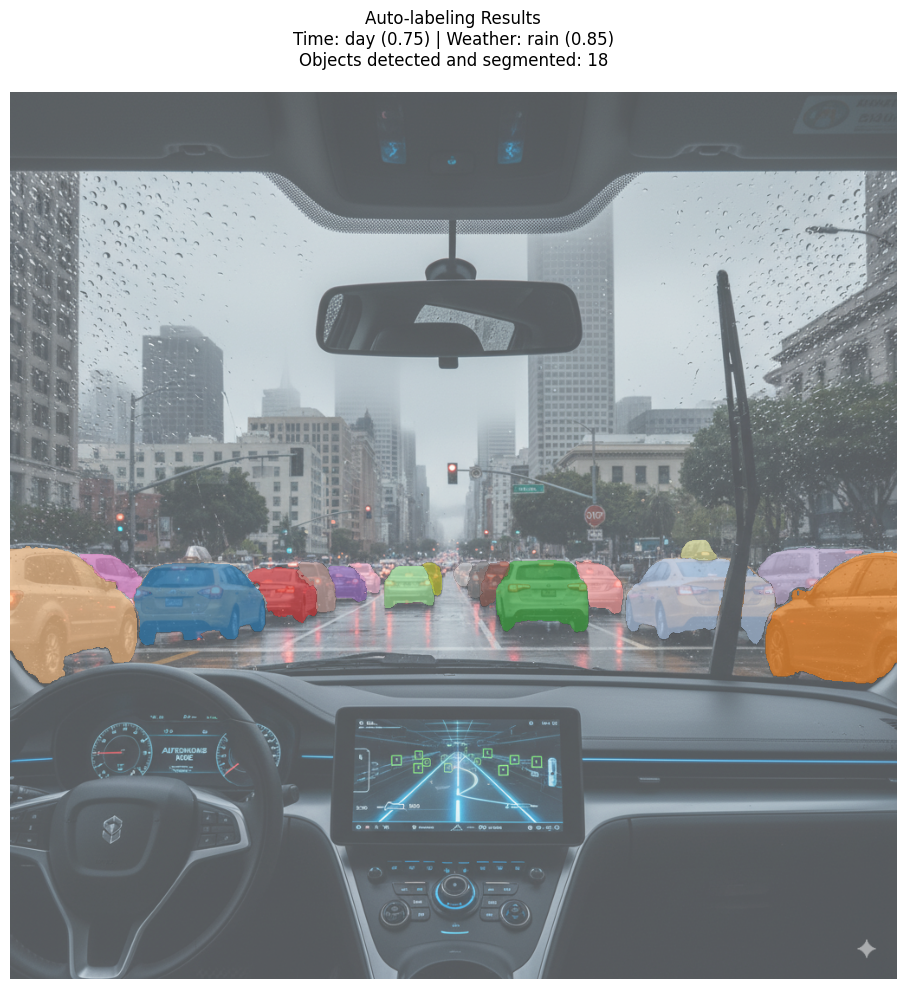

In [31]:
# Visualize complete pipeline results
visualize_pipeline_results(
    image,
    result['time_of_day'],
    result['time_confidence'],
    result['weather'],
    result['weather_confidence'],
    result['masks']
)

Let's do the other images as well:

Processing image 1/4...
  Found 3 objects (vehicles and people).
  Time: day (0.86)
  Weather: fog (0.99)
Processing image 2/4...
  Found 12 objects (vehicles and people).
  Time: day (0.75)
  Weather: normal (0.62)
Processing image 3/4...
  Found 0 objects (vehicles and people).
  Time: sunset or sunrise (0.95)
  Weather: fog (0.78)
Processing image 4/4...
  Found 18 objects (vehicles and people).
  Time: day (0.75)
  Weather: rain (0.85)


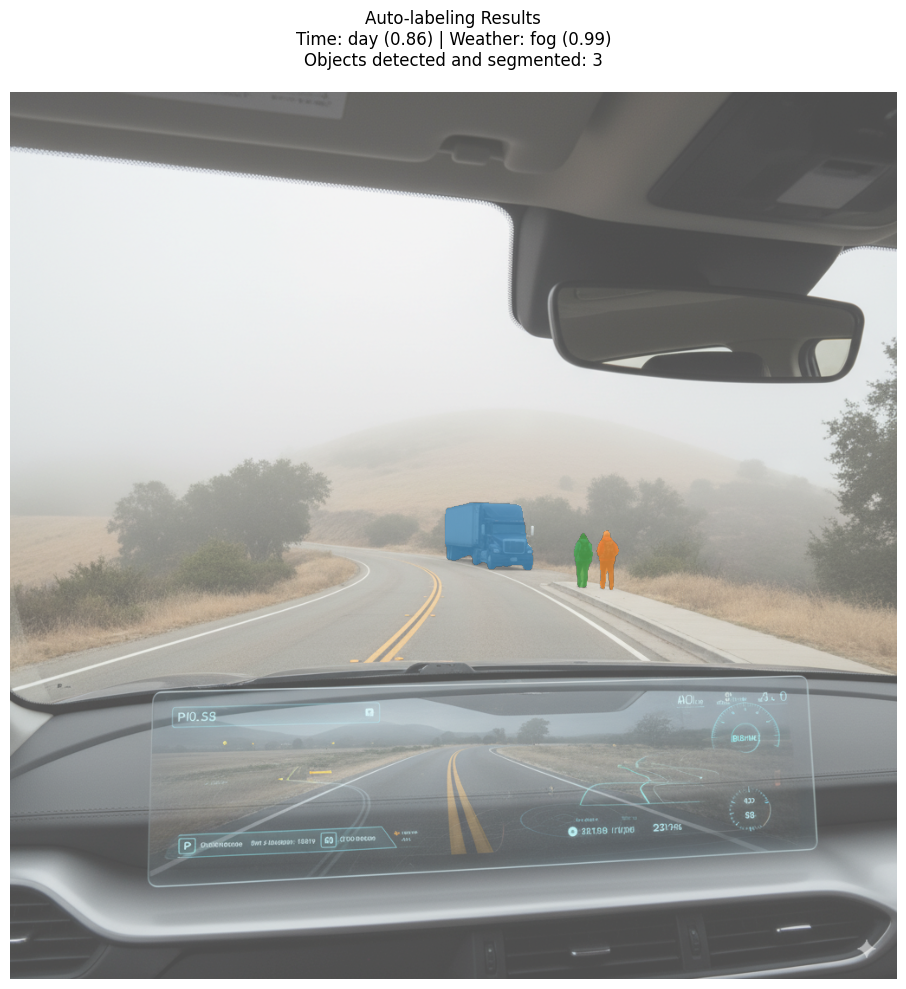

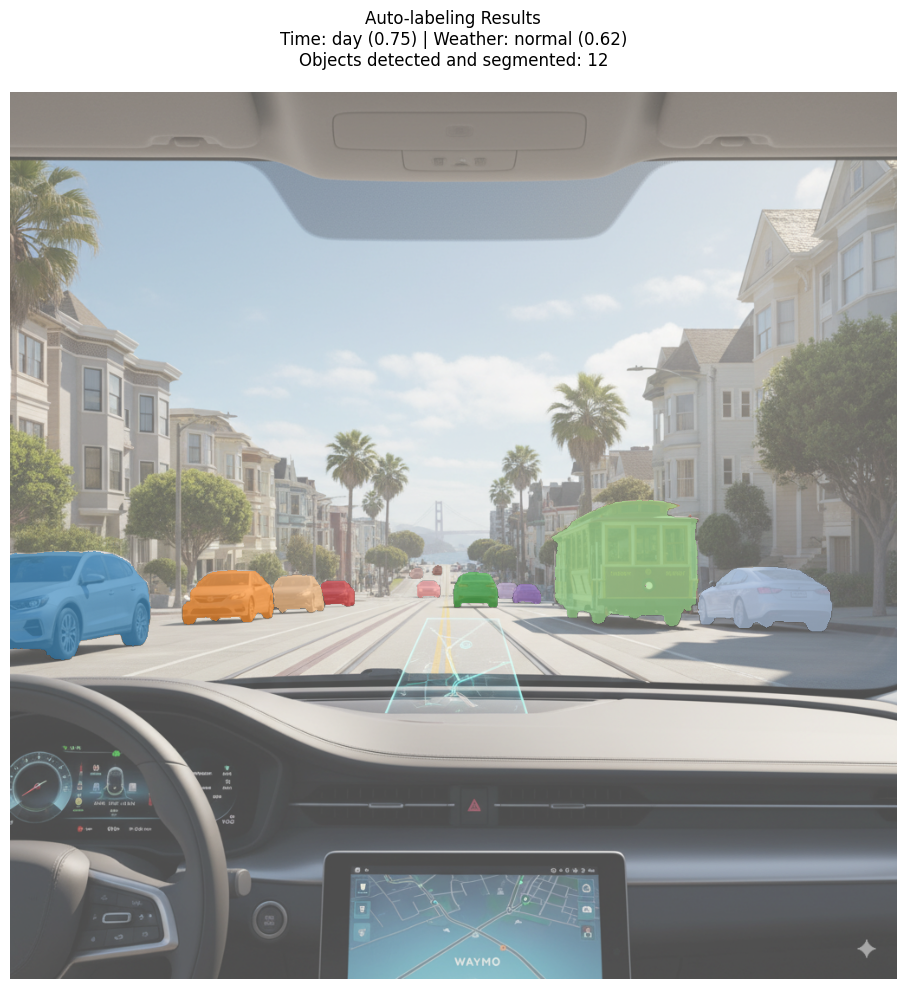

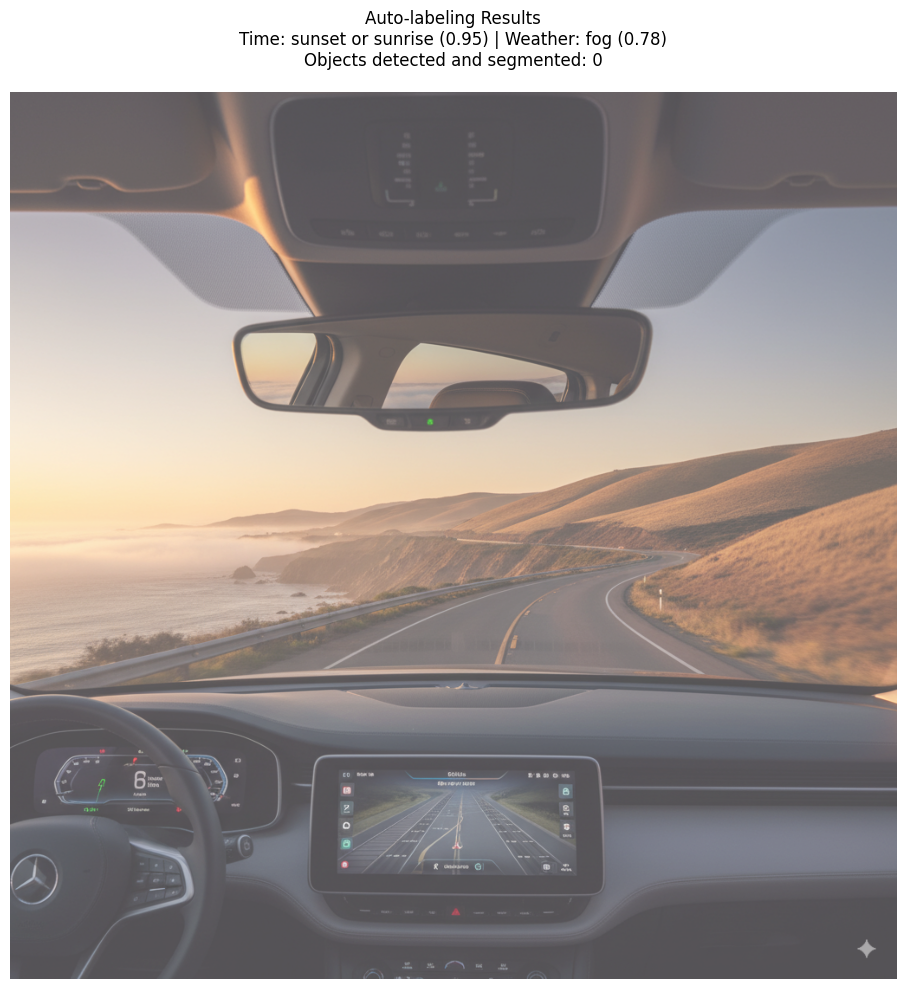

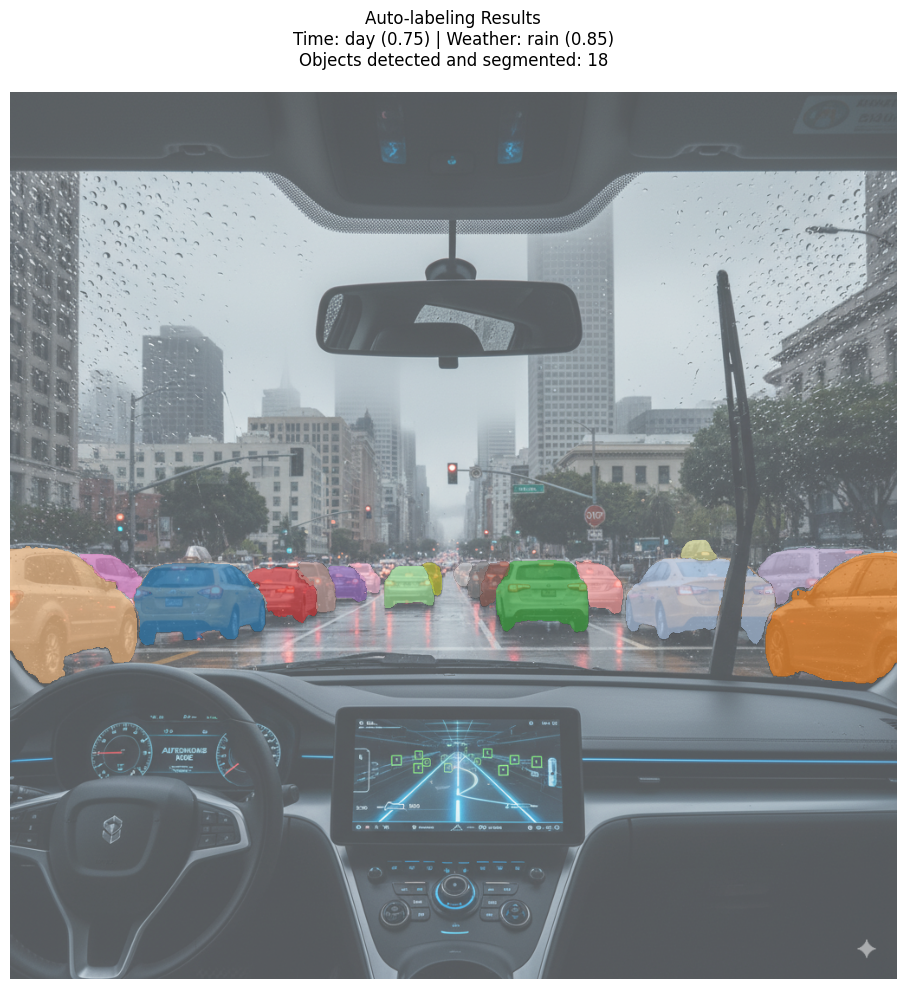

In [32]:
import glob

paths = glob.glob("../images/*.png")

images = [Image.open(x).convert("RGB") for x in paths]

results = auto_label_driving_scene(images)

for image, result in zip(images, results):

    visualize_pipeline_results(
        image,
        result['time_of_day'],
        result['time_confidence'],
        result['weather'],
        result['weather_confidence'],
        result['masks']
    )

    